# CLUE_exRevEngage

This is a script that determines and standardizes the amount of student engagement based on Zoom audio transcripts and chat logs of CLUE exam reviews.

In [1]:
import os
from pathlib import Path
import openpyxl
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from adjustText import adjust_text

In [2]:
# Convert time stamp into total seconds.
def timeParse(s):
    timeRegex = re.compile(r'(\d\d):(\d\d):(\d\d)')
    mo = timeRegex.search(s)
    time = int(mo.group(1))*(60**2) + int(mo.group(2))*60 + int(mo.group(3)) # in sec
    return time

In [3]:
# Determine duration of verbal from audio transcript.
def processAud(filename, tutors, s_prob, e_prob):
    file = open(filename,'r')
    lines = file.readlines()
    
    duration = 0 # in sec
    
    for i in range (3, len(lines)-1, 4):
        timeRegex = re.compile(r'(.*) --> (.*)')
        mo1 = timeRegex.search(lines[i])
        s_stud = timeParse(mo1.group(1))
        e_stud = timeParse(mo1.group(2))
    
        nameRegex = re.compile(r'(.*):\s(.*)')
        mo2 = nameRegex.search(lines[i+1])
        if mo2 is not None:
            name = mo2.group(1).split(':')[0]
        
        if ((s_prob<=s_stud)and(e_stud<=e_prob)) and (name not in tutors):
            duration += e_stud - s_stud

    return duration

In [4]:
# Determine number of chat messages from chat log.
def processChat(filename, tutors, s, e):
    file = open(filename, 'r')
    lines = file.readlines()
    
    count = 0
    
    for l in lines:
        # Pattern match time, name, and comment
        lineRegex = re.compile(r'(.*)\t(.*):\t(.*)')
        mo = lineRegex.search(l)
        
        t = timeParse(mo.group(1))
        name = mo.group(2)
        
        # Count question if within start/end and name is not either tutor
        if (s<=t<=e) and (name not in tutors): 
            count += 1
        
    return count

In [5]:
# Standardize both duration of verbal Q's and # chat Q's
def stdData(path):
    # Create dataframe df and standardize 'Duration' and 'Number'
    df = pd.read_excel(path)
    scaler = StandardScaler()
    df[['Duration Verbal','Number Chat']] = scaler.fit_transform(df[['Duration Verbal','Number Chat']])
#     df.head()

    # Create plot with title and labeled axes
    fig, ax = plt.subplots(facecolor='w', figsize=(7.5,6), dpi=200)
    fig = sns.scatterplot(x='Duration Verbal', y='Number Chat', data=df,
                          hue='Chapter', palette="deep", s=75)
    
    plt.title('Model Plot of Student Engagement with CHEM 237 Concepts (Aut22)', fontweight='bold', y=1.02)
    plt.xlabel('Standardized Verbal Duration', fontweight='bold')
    plt.xlim([-2.0,3.75])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.ylabel('Standardized Number of Chat Messages', fontweight='bold')
    plt.ylim([-1.75,1.75])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    

    # Draw horizontal and vertical axes
    plt.axhline(color='black', linestyle=':')
    plt.axvline(color='black', linestyle=':')
    
    # Shift legend outside of plot
    plt.legend(title='Chapter',bbox_to_anchor=(1.04, 0.5), loc='center left', borderaxespad=0)

    # Label each data point with concept name
#     for i in range(0,df.shape[0]):
#          plot.text(df.iloc[i]['Duration Verbal']+0.05,
#                    df.iloc[i]['Number Chat'],
#                    df.iloc[i]['Concept'],
#                    horizontalalignment='left',
#                    fontsize='small',
#                    color='black')
    texts = []
    for x, y, z in zip(df['Duration Verbal'], df['Number Chat'], df['Concept']):
        texts.append(fig.text(x, y, z))
#     adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='c', lw=0.5))
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='c', lw=0.5))

#     # Save plot
#     plotName = input('Save plot as: ')
#     plt.savefig(plotName)

In [6]:
def main():
    # Request user input for data folder absolute path.
#     dataFolder = input('Enter data folder absolute path: ')
    dataFolder = r'C:\Users\ianja\OneDrive - UW\CLUE\2022_1_Aut\Data'
    os.chdir(dataFolder)
#     excelFilename = input('Enter data Excel file name: ')
    excelFilename = r'2022_Aut_CHEM237_StudentEngagement.xlsx'
    wb = openpyxl.load_workbook(excelFilename)
    sh = wb['Sheet1']
    
    # Loops through all rows of Excel sheet and extract main information.
    for i in range(2, sh.max_row+1):
        # Main information
        audTrans_filename = sh.cell(row=i, column=2).value
        chat_filename = sh.cell(row=i, column=3).value
        tutors = []
        tutors.append(sh.cell(row=i, column=4).value)
        tutors.append(sh.cell(row=i, column=5).value)
        start = timeParse(sh.cell(row=i, column=8).value)
        end = timeParse(sh.cell(row=i, column=9).value)
        
        # Processes audio transcript for duration of verbal
        dur_aud = processAud(audTrans_filename, tutors, start, end)
        sh.cell(row=i, column=10,value=dur_aud)
    
        # Processes chat file for number of chat messages
        num_chat = processChat(chat_filename, tutors, start, end)
        sh.cell(row=i, column=11,value=num_chat)

    
    # Save and close Excel file.
    wb.save(Path(dataFolder) / excelFilename)
    wb.close()
    
    # Standardize the data.
    stdData(Path(dataFolder) / excelFilename)

Analysis completed.


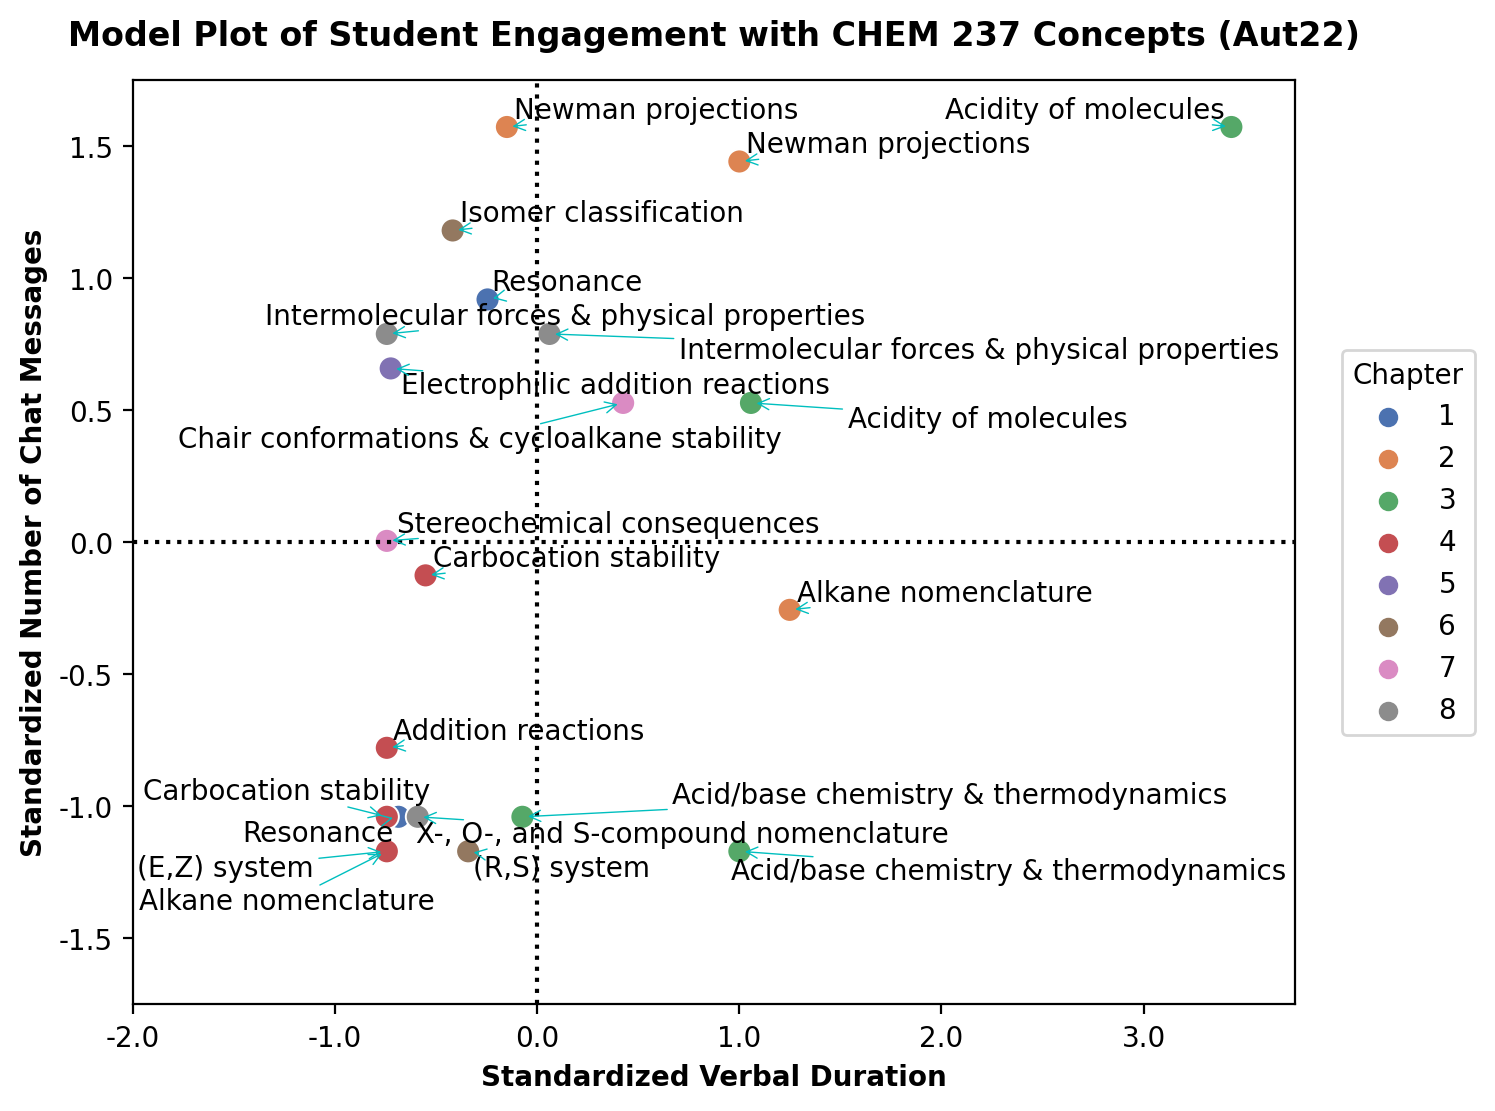

In [7]:
main()
print('Analysis completed.')